<a href="https://colab.research.google.com/github/lauvsong/raw_iris/blob/main/raw_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris classification with raw numpy

basic softmax based iris with **ZERO SCIKIT-LEARN**
(except importing iris)

*refer to hands-on machine learning with scikit-learn keras and tensorflow*

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
X = iris["data"][:, (2,3)] # length, width
y = iris["target"]

In [5]:
X_with_bias = np.c_[np.ones([len(X),1]), X]

In [6]:
np.random.seed(2042)

## train test split

In [7]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

## one hot encoding

In [8]:
def to_one_hot(y):
  n_classes = y.max() + 1
  m = len(y)
  Y_one_hot = np.zeros((m, n_classes))
  Y_one_hot[np.arange(m), y] = 1
  return Y_one_hot

In [9]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [10]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [11]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

## softmax

In [12]:
def softmax(logits):
  exps = np.exp(logits)
  exp_sums = np.sum(exps, axis=1, keepdims=True)
  return exps / exp_sums

In [13]:
n_inputs = X_train.shape[1] # 2 features and bias ( == 3 )
n_outputs = len(np.unique(y_train)) # 3 iris classes ( == 3)

### Cost function

$ J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)} $

### Gradient function

$ \nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}} $

In [14]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7 # avoid nan (ex. log(0))

theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
  logits = X_train.dot(theta) # softmax score
  Y_proba = softmax(logits)
  if iteration % 500 == 0:
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    print(iteration, loss)
  error = Y_proba - Y_train_one_hot
  gradients = 1/m * X_train.T.dot(error)
  theta = theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.42786510939287936
4500 0.41060071429187134
5000 0.3956780375390374


In [15]:
theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [18]:
logits = X_valid.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

## early stopping

In [19]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1
best_loss = np.infty

theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
  logits = X_train.dot(theta)
  Y_proba = softmax(logits)
  error = Y_proba - Y_train_one_hot
  gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
  theta = theta - eta * gradients

  # caculate loss using validation set
  logits = X_valid.dot(theta)
  Y_proba = softmax(logits)
  xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
  l2_loss = 1/2 * np.sum(np.square(theta[1:]))  # Ridge regularization
  loss = xentropy_loss + alpha * l2_loss

  if iteration % 500 == 0:
    print(iteration, loss)
  if loss < best_loss:
    best_loss = loss
  else:
    print(iteration - 1, best_loss)
    print(iteration, loss, "early stopped")
    break

0 4.737727518674819
500 0.5665936705360495
1000 0.5416998332012445
1500 0.5350529375648612
2000 0.5330543544990185
2500 0.5325716489587929
2701 0.5325452746042683
2702 0.5325452748471854 early stopped


In [20]:
logits = X_valid.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

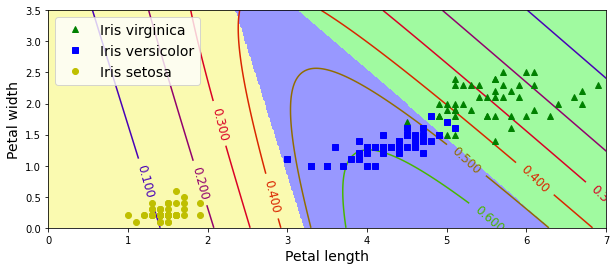

In [23]:
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [30]:
logits = X_test.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333